In [1]:
from numbers import Number

import torch
from torch.distributions import Exponential
from torch.distributions import Uniform
from torch.distributions import Normal
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import broadcast_all
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 


## Kolmogorov-Smirnov Test
The following example executes the KS test for the following histogram $\vec{h}$ with $n = 1076$


n  tensor(1076)


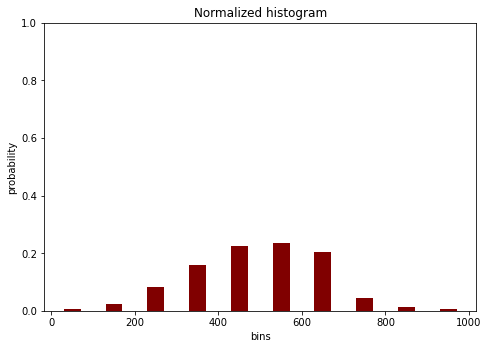

mean  tensor(593.0297)
std  tensor(154.9275)
cdfNormalIdeal  torch.Size([10])
cdfEmpirical  torch.Size([10])


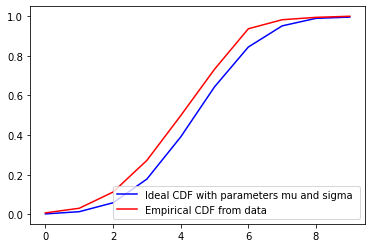

|cdfNormalIdeal - cdfEmpirical| =  tensor(0.1075)


In [8]:
def plot_bar(bins, histogram, axis_x_label, axis_y_label, title):    
    
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])
    #assumes edges are received 
    axes.bar(bins[0:-1].tolist(), histogram.tolist(), color ='maroon', width = 40.4)
    plt.xlabel(axis_x_label)
    plt.ylabel(axis_y_label)
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()


def save_columns_csv(column1_tensor, column2_tensor):
    #to 2d array
    column1_tensor = column1_tensor.unsqueeze(0)
    column2_tensor = column2_tensor.unsqueeze(0)
    matrix = torch.cat((column1_tensor, column2_tensor), 0)
    print("matrix")
    print(matrix)
    pd.DataFrame(matrix.numpy()).to_csv("sample_1.csv")
    
    
#events ocurrences
histogram = torch.tensor([8, 25, 88, 172, 243, 252, 220, 49, 13, 6])
#events
histogramX = torch.tensor([50, 150, 250, 350, 450, 550, 650, 750, 850, 950, 1000])



n = histogram.sum()
print("n ", n)
histogramNorm = histogram / n
histogramNorm2 = histogram / (n - 1)
#save_columns_csv(histogramX, histogram)


#calculate cumulative sum
cdfEmpirical = torch.cumsum(histogramNorm, dim = 0)
#number of observations
plot_bar(histogramX.numpy(), histogramNorm.numpy(), "bins", "probability", "Normalized histogram")

#get sample stats
meanHist = (histogramX[1:] * histogramNorm).sum()
stdHist = torch.sqrt((histogramNorm2 * (histogramX[1:] - meanHist) ** 2).sum())
print("mean ", meanHist)
print("std ", stdHist)
#Create ideal CDF
normalDensity_ideal = Normal(meanHist, stdHist)
cdfNormalIdeal = normalDensity_ideal.cdf(histogramX[1:])

#Compare the empirical and ideal distributions
print("cdfNormalIdeal ", cdfNormalIdeal.shape)
print("cdfEmpirical ", cdfEmpirical.shape)

difference = torch.abs(cdfNormalIdeal - cdfEmpirical)
dn = torch.max(difference)

#plot both distributions
fig, ax = plt.subplots()
ax.plot(cdfNormalIdeal, "-b", label = "Ideal CDF with parameters mu and sigma ")
ax.plot(cdfEmpirical, "-r",  label = "Empirical CDF from data")
leg = ax.legend()
plt.show()
print("|cdfNormalIdeal - cdfEmpirical| = ", dn)

In [51]:
print("cdfNormalIdeal ", cdfNormalIdeal)

cdfNormalIdeal  tensor([0.5864, 0.8053, 0.9336, 0.9840, 0.9973, 0.9997, 1.0000, 1.0000, 1.0000,
        1.0000])


The value $D_n$ obtained is checked with a confidence $1-\alpha = 0.95$ (with $\alpha=0.05$), using the Kolgomorov distribution table, and we verify that $D_n < D_{n,\alpha}$, which for this case we do check that $0.1077 < 1.223 / \sqrt{1076}$, which is $0.1172 < 0.0373$. This means that the hypothesis $H_0$ regarding that the histogram $\vec{h}$ has been generated from a normal distribution with the given parameters, is rejected. Therefore the data does is not likely to be drawn from a Normal distribution with the sample means and standard deviations calculated. 

## Using scipy.stats
Scipy.stats implements several different packages for statistical tests. The KS test is one of them.
See more details here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

In [15]:

import torch
import numpy as np
from scipy import stats
rng = np.random.default_rng()
sample_empirical = stats.norm.cdf
n = 100
#sample 1 with parameters mu_1 and sigma_1
sample_1 = torch.normal(90, 3, size=(1, 100))[0]

#sample 2 with parameters mu_2 and sigma_2
sample_2 = torch.normal(90.05, 3, size=(1, 100))[0]


#if p value < 0.05, the hypothesis of both samples coming from the same distribution is rejected
#if p value > 0.05, the hypothesis that states:  both distribution are equal is accepted
stats.kstest( sample_1.numpy(), sample_2.numpy())


KstestResult(statistic=0.18, pvalue=0.07822115797841851)

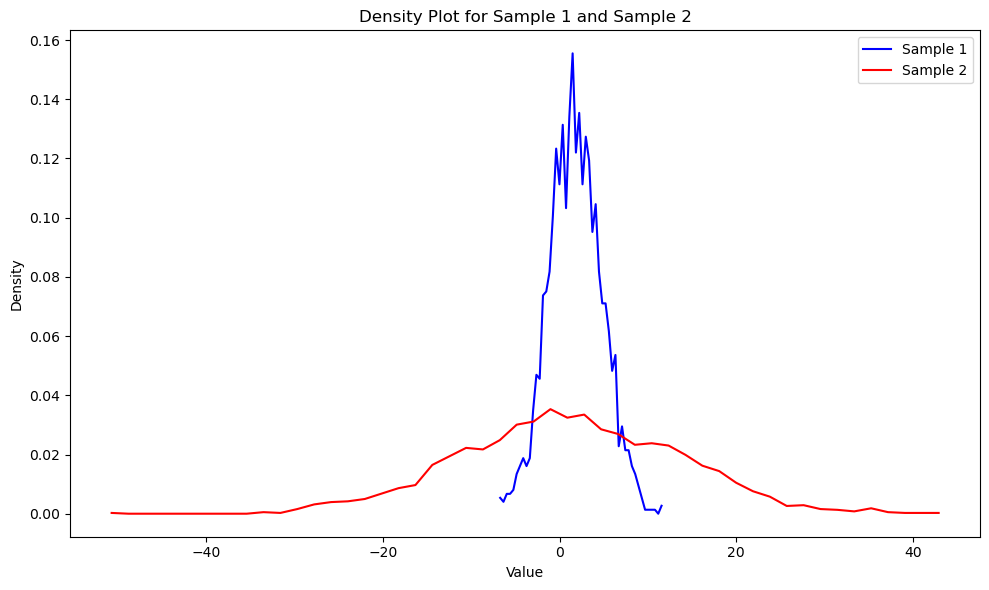

In [20]:
hist1, bins1 = np.histogram(sample_1.numpy(), bins=50, density=True)
hist2, bins2 = np.histogram(sample_2.numpy(), bins=50, density=True)

plt.figure(figsize=(10, 6))

plt.plot(bins1[:-1], hist1, label='Sample 1', color='blue')
plt.plot(bins2[:-1], hist2, label='Sample 2', color='red')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot for Sample 1 and Sample 2')
plt.legend()

plt.tight_layout()
plt.show()

## Jarque-Bera test
Using the Jarque-Bera test

In [16]:
import torch
import numpy as np
from scipy import stats
n = 1000
normal_dist = torch.distributions.Normal(torch.tensor([10.0]), torch.tensor([2]))
gaussian_sample_1 = normal_dist.sample((n,1)).squeeze()

print("Gaussian sample: ")
res = stats.jarque_bera(gaussian_sample_1)
print(res)
#if p value < 0.05, the hypothesis that states the distribution is normal is rejected
#if p value > 0.05, the hypothesis that states the distribution is normal is accepted

Gaussian sample: 
Jarque_beraResult(statistic=0.3184426975797597, pvalue=0.8528075701521607)


In [17]:
#create exponential sample

lambda_dist = 0.1
exponential_dist = torch.distributions.exponential.Exponential(lambda_dist)
exponential_sample = exponential_dist.sample((n,1)).squeeze()
print("Exponential sample: ")
res = stats.jarque_bera(exponential_sample)
print(res)

#if p value < 0.05, the hypothesis that states the distribution is normal is rejected
#if p value > 0.05, the hypothesis that states the distribution is normal is accepted

Exponential sample: 
Jarque_beraResult(statistic=1176.7725167473352, pvalue=0.0)


# Homoscedasticity test

In [12]:
from scipy import stats

normal_dist = torch.distributions.Normal(torch.tensor([10.0]), torch.tensor([2]))
gaussian_sample_1 = normal_dist.sample((n,1)).squeeze()
normal_dist = torch.distributions.Normal(torch.tensor([10.0]), torch.tensor([6.1]))
gaussian_sample_2 = normal_dist.sample((n,1)).squeeze()

res = stats.bartlett(gaussian_sample_1.numpy(), gaussian_sample_2.numpy())

print("Barlett test result \n ", res)

Barlett test result 
  BartlettResult(statistic=983.3693216321805, pvalue=7.39956488612444e-216)


References

[1]
https://www.itl.nist.gov/div898/handbook/eda/section3/eda357.htm

[2]
Snedecor, George W. and Cochran, William G. (1989), Statistical Methods, Eighth Edition, Iowa State University Press.

[3]
Park, C. and Lindsay, B. G. (1999). Robust Scale Estimation and Hypothesis Testing based on Quadratic Inference Function. Technical Report #99-03, Center for Likelihood Studies, Pennsylvania State University.

[4]
Bartlett, M. S. (1937). Properties of Sufficiency and Statistical Tests. Proceedings of the Royal Society of London. Series A, Mathematical and Physical Sciences, Vol. 160, No.901, pp. 268-282.

[5]
C.I. BLISS (1952), The Statistics of Bioassay: With Special Reference to the Vitamins, pp 499-503, DOI:10.1016/C2013-0-12584-6.

[6]
B. Phipson and G. K. Smyth. “Permutation P-values Should Never Be Zero: Calculating Exact P-values When Permutations Are Randomly Drawn.” Statistical Applications in Genetics and Molecular Biology 9.1 (2010).

[7]
Ludbrook, J., & Dudley, H. (1998). Why permutation tests are superior to t and F tests in biomedical research. The American Statistician, 52(2), 127-132.